<a href="https://colab.research.google.com/github/benardt/ML/blob/main/oring_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import shutil
#shutil.unpack_archive("/content/drive/My Drive/data/archive_pad_oring.tar.gz", "/tmp")
shutil.unpack_archive("/content/drive/My Drive/data/oring5.zip", "/tmp")
shutil.unpack_archive("/content/drive/My Drive/data/test.zip", "/tmp")

Mounted at /content/drive


In [ ]:
import os
import time
from PIL import Image, ImageOps

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses
!pip install import-ipynb
import import_ipynb
from importlib import reload # reload 

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=c5c6a21792f45a2587527f886734dc69f763a0da3eb94db697d4b1051f915b57
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
!rm -r './mylib.ipynb'
!cp '/content/drive/My Drive/Colab Notebooks/mylib.ipynb' .
import mylib as ml
reload(ml)
ml.mytest('YES')

importing Jupyter notebook from mylib.ipynb
test import... YES


0 torch.Size([16, 1, 500, 500]) torch.Size([16, 1, 250, 250])


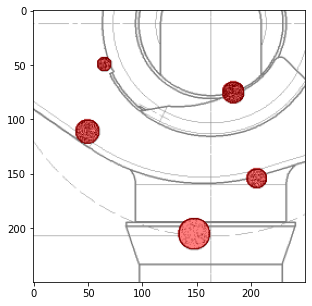

1 torch.Size([16, 1, 500, 500]) torch.Size([16, 1, 250, 250])


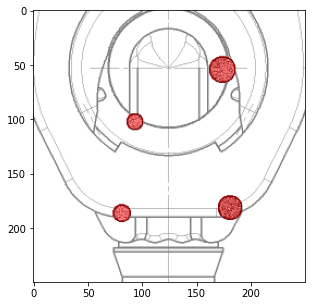

2 torch.Size([16, 1, 500, 500]) torch.Size([16, 1, 250, 250])


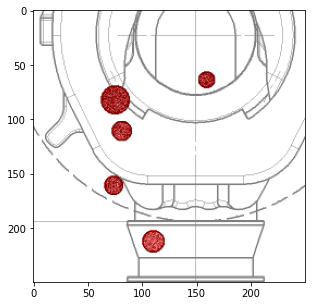

In [ ]:
#DATA_DIR = '/tmp/dataset/pad_oring'
DATA_DIR = '/tmp/oring5'

#INPUT_SIZE = 1000
OUTPUT_SIZE = 250
BATCH_SIZE = 16

trans_input = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                      #transforms.Resize(INPUT_SIZE,interpolation=transforms.InterpolationMode.NEAREST),
                      transforms.ToTensor()])

trans_output = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                      transforms.Resize(OUTPUT_SIZE,interpolation=transforms.InterpolationMode.NEAREST),
                      #transforms.CenterCrop(OUTPUT_SIZE),
                      transforms.ToTensor()])   

class OringLandmarksDataset(Dataset):
    """Landmarks dataset."""

    def __init__(self, pkl_file, root_dir):
        """
        Args:
            pkl_file (string): Path to the pickle file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.root_dir = root_dir
        self.imgs = list(sorted(os.listdir(os.path.join(root_dir, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root_dir, "Masks"))))

    def __len__(self):
        return len(self.imgs)

    def transform(self, x, y):

        image = trans_input(x)
        mask = trans_output(y)
        return image, mask

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, "PNGImages", self.imgs[idx])
        im_invert = Image.open(img_name).convert('L')
        image = ImageOps.invert(im_invert)

        path = self.imgs[idx]

        mask_name = os.path.join(self.root_dir, "Masks", self.masks[idx])
        mask_invert = Image.open(mask_name).convert('L')
        mask = ImageOps.invert(mask_invert)

        x, y = self.transform(image, mask)
        return x, y


trans_dataset = OringLandmarksDataset(pkl_file='data.pkl',root_dir=DATA_DIR)

train_len = int(0.6*len(trans_dataset))
valid_len = len(trans_dataset)-train_len
TrainData, ValidData = torch.utils.data.random_split(trans_dataset,[train_len, valid_len])

dataloader = { 'train':[],'valid':[]}
dataloader['train'] = DataLoader(TrainData,
                        batch_size=BATCH_SIZE,
                        shuffle=True,pin_memory=True,num_workers=2)
dataloader['valid'] = DataLoader(ValidData,
                        batch_size=BATCH_SIZE,
                        shuffle=True,pin_memory=True,num_workers=2)

for i_batch, (x,y) in enumerate(dataloader['train']):
    print(i_batch, x.size(), y.size())
    # observe nth batch and stop.
    x = transforms.functional.resize(x, OUTPUT_SIZE)
    pix = np.array(y[0].squeeze())
    #print('y: ',np.unique(pix,return_counts=True))
    ml.images_show(x[0],y[0],5)
    if i_batch == 2:
        break


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        nb_channels = 1
        ker_size = 21

        # optuma (régler les hyperparamètres)
        self.conv1 = nn.Conv2d(
            in_channels = nb_channels,
            out_channels = 128, # à changer
            kernel_size = ker_size,
            stride=1,
            padding = int((ker_size-1)/2)
            )
        torch.nn.init.xavier_uniform_(self.conv1.weight)

        self.pool1 = nn.MaxPool2d(
            kernel_size = ker_size,
            stride = 2,
            padding = int((ker_size-1)/2)
        )
        # si filtre (ou_channels) réduire ker_size
        # self.maxpool1 = nn.MaxPool2d(ker_size,padding_size)
        # avgerage pool2D !! priority
        ker_size = 3
        self.conv2 = nn.Conv2d(
            in_channels = 128,
            out_channels = 64,
            kernel_size = ker_size,
            padding = int((ker_size-1)/2)
            )
        torch.nn.init.xavier_uniform_(self.conv2.weight)

        ker_size = 3
        self.pool2 = nn.MaxPool2d(
            kernel_size = ker_size,
            stride = 1,
            padding = int((ker_size-1)/2)
        )

        # ker_size = 3
        # self.conv3 = nn.Conv2d(
        #     in_channels = 32,
        #     out_channels = 32,
        #     kernel_size = ker_size,
        #     padding = 0
        #     )
        
        # torch.nn.init.xavier_uniform_(self.conv3.weight)
        # ker_size = 3
        # self.pool3 = nn.MaxPool2d(
        #     kernel_size = ker_size,
        #     stride = 2,
        #     padding = 0
        # )

        ker_size = 1
        self.conv4 = nn.Conv2d(
            in_channels = 64,
            out_channels = 1,
            kernel_size = ker_size,
            padding = 0
            )
        torch.nn.init.xavier_uniform_(self.conv4.weight)

    # x represents our data
    def forward(self, x):
        # Pass data through conv1
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # x = F.relu(self.conv3(x))
        # x = self.pool3(x)

        x = self.conv4(x)

        # Apply softmax to x
        #output = F.log_softmax(x, dim=1)
        output = x
        return output


In [ ]:
def train_model2(model,iterator, num_epochs=10):
    accuracy = ml.DiceLoss()
    liveloss = PlotLosses()
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'valid']:

            running_loss = 0.0
            running_corrects = 0

            t = tqdm(iter(iterator[phase]), total=len(iterator[phase]))
            for x, y in t:
                x,y = x.to(device),y.to(device)

                if phase == 'train':
                    model.train()
                    yhat = model(x)
                    #hout,wout = yhat.size()[2],yhat.size()[3]
                    #Ty = transforms.functional.resize(y,size=(hout,wout),interpolation=transforms.InterpolationMode.NEAREST)
                    #Ty = transforms.functional.center_crop(y, 448)
                    loss = criterion(yhat, y)

                    for param in model.parameters():
                        param.grad = None
                    #optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                else:
                    model.eval()
                    with torch.no_grad():
                        yhat = model(x)
                        #hout,wout = yhat.size()[2],yhat.size()[3]
                        #Ty = transforms.functional.resize(y,size=(hout,wout),interpolation=transforms.InterpolationMode.NEAREST)
                        #Ty = transforms.functional.center_crop(y, 448)
                        loss = criterion(yhat, y)
                        
                # loss
                running_loss += loss.detach() * x.detach().size(0)

                # accuracy
                threshold = 0.0
                preds = (yhat.detach() > threshold)*1
                acc = 100*(1 - accuracy(preds, y.detach()))
                running_corrects += acc * x.detach().size(0)
                #del Ty

            epoch_loss = running_loss.item() / len(iterator[phase].dataset)
            epoch_acc = running_corrects.item() / len(iterator[phase].dataset)
            
            prefix = ''
            if phase == 'valid':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
        
        liveloss.update(logs)
        liveloss.send()

Model description:
Net(
  (conv1): Conv2d(1, 128, kernel_size=(21, 21), stride=(1, 1), padding=(10, 10))
  (pool1): MaxPool2d(kernel_size=21, stride=2, padding=10, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

Model parameters:
+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |   56448    |
|  conv1.bias  |    128     |
| conv2.weight |   73728    |
|  conv2.bias  |     64     |
| conv4.weight |     64     |
|  conv4.bias  |     1      |
+--------------+------------+
Total Trainable Params: 130433

Check images:
torch.Size([8, 1, 500, 500]) torch.Size([8, 1, 250, 250]) torch.Size([8, 1, 250, 250])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


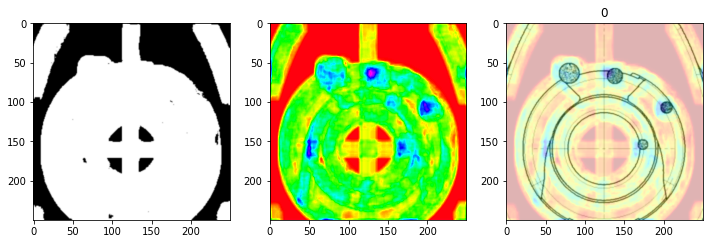

torch.Size([8, 1, 500, 500]) torch.Size([8, 1, 250, 250]) torch.Size([8, 1, 250, 250])


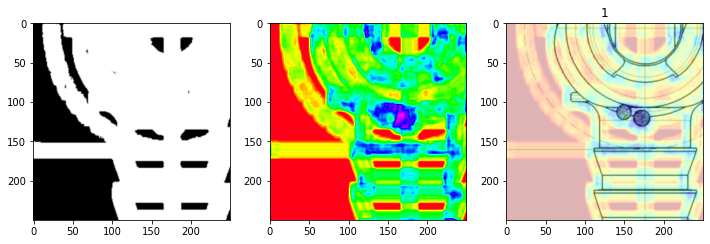

In [ ]:
model = Net().to(device)
print('Model description:')
print(model)
print('\nModel parameters:')
ml.count_parameters(model)
print('\nCheck images:')
model.eval()
with torch.no_grad():
    for i, (x,y) in enumerate(dataloader['valid']):
        x,y = x.to(device),y.to(device)
        out = model(x)
        print(x.size(),y.size(),out.size())
        Tx = transforms.functional.resize(x, OUTPUT_SIZE)
        ml.tensShow(Tx,out,i)
        if i == 1:
            break

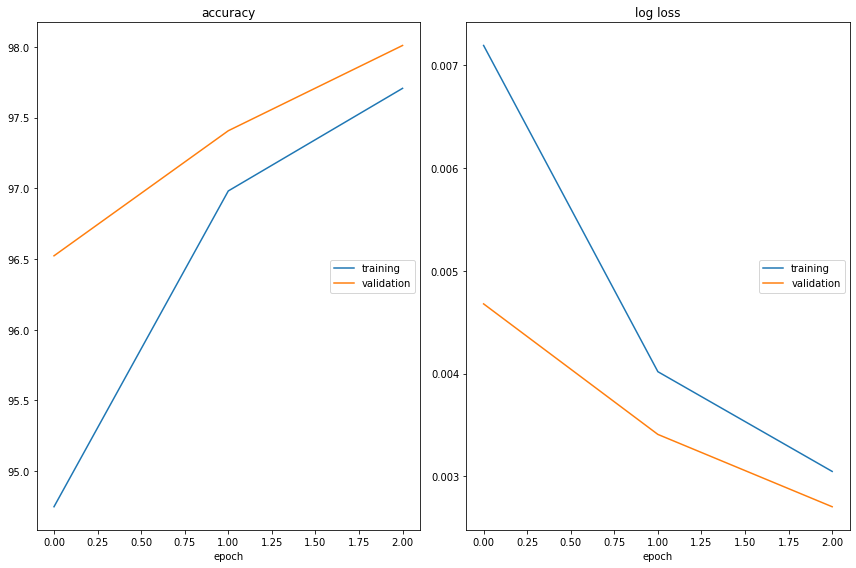

accuracy
	training         	 (min:   94.749, max:   97.707, cur:   97.707)
	validation       	 (min:   96.523, max:   98.010, cur:   98.010)
log loss
	training         	 (min:    0.003, max:    0.007, cur:    0.003)
	validation       	 (min:    0.003, max:    0.005, cur:    0.003)


KeyboardInterrupt: ignored

In [ ]:
torch.cuda.empty_cache()

print('\nTrainning...')
train_model2(model,dataloader,30)

cuda

Check:


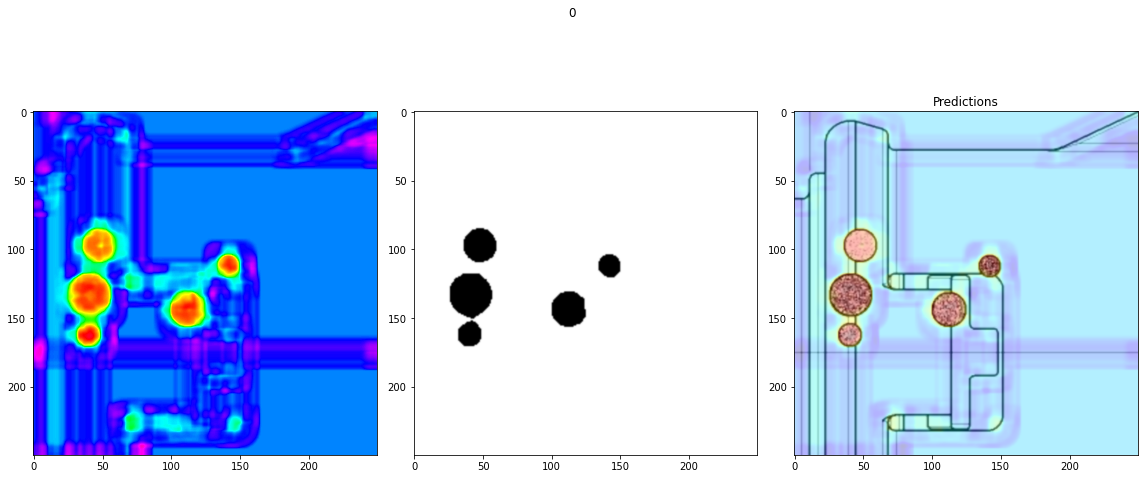

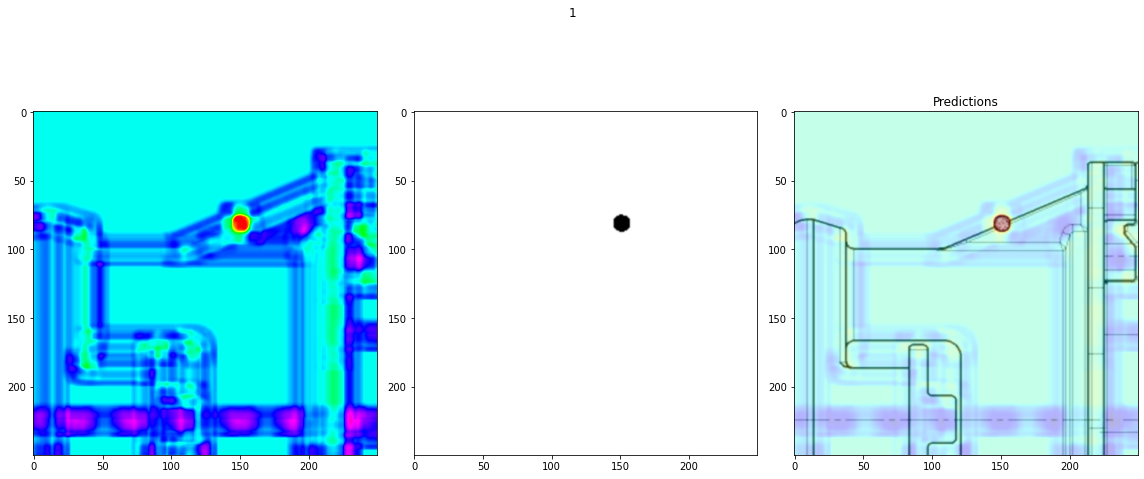

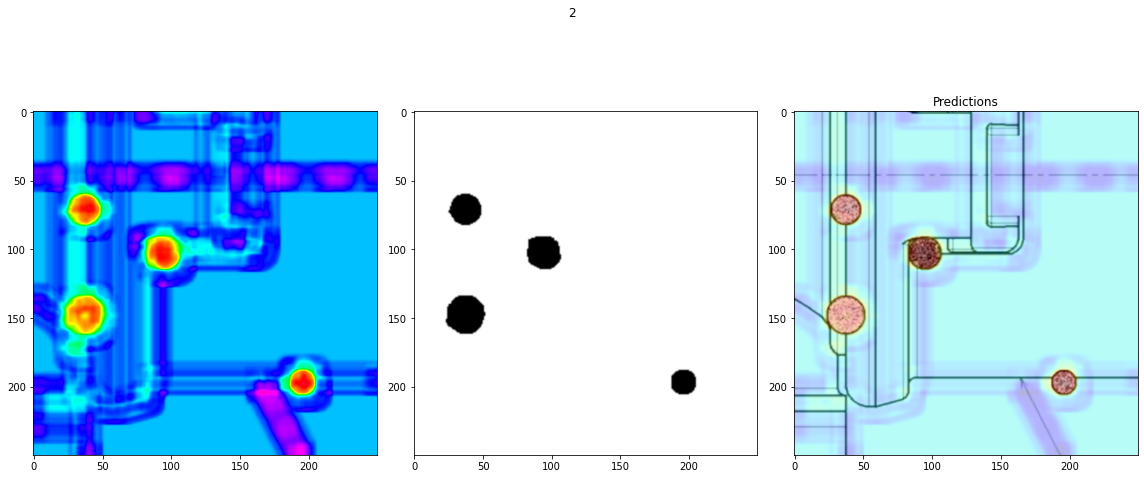

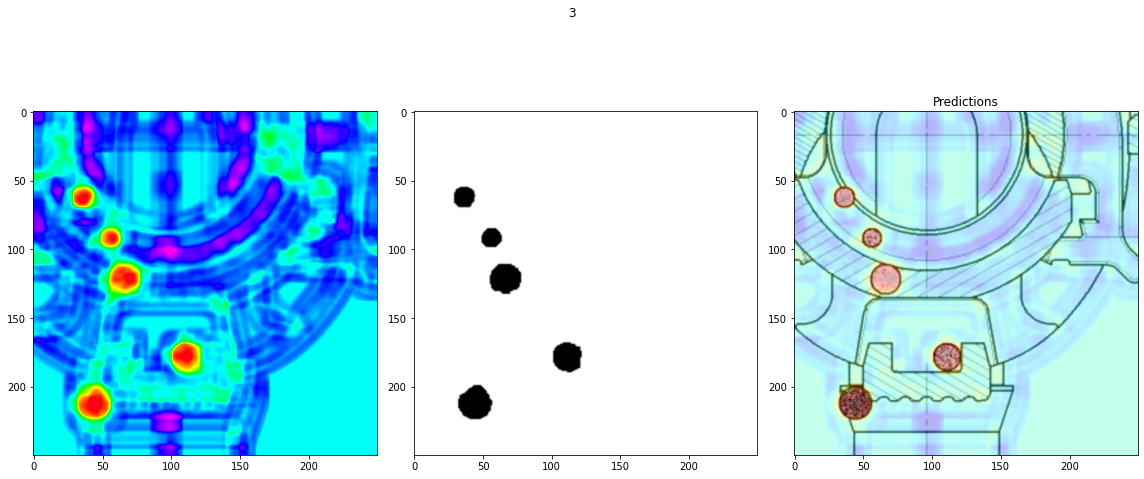

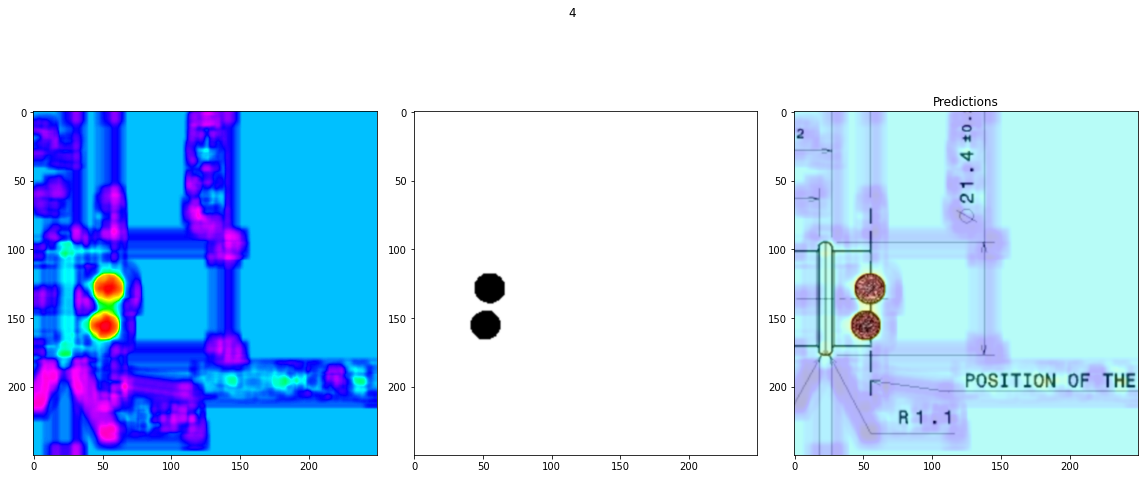

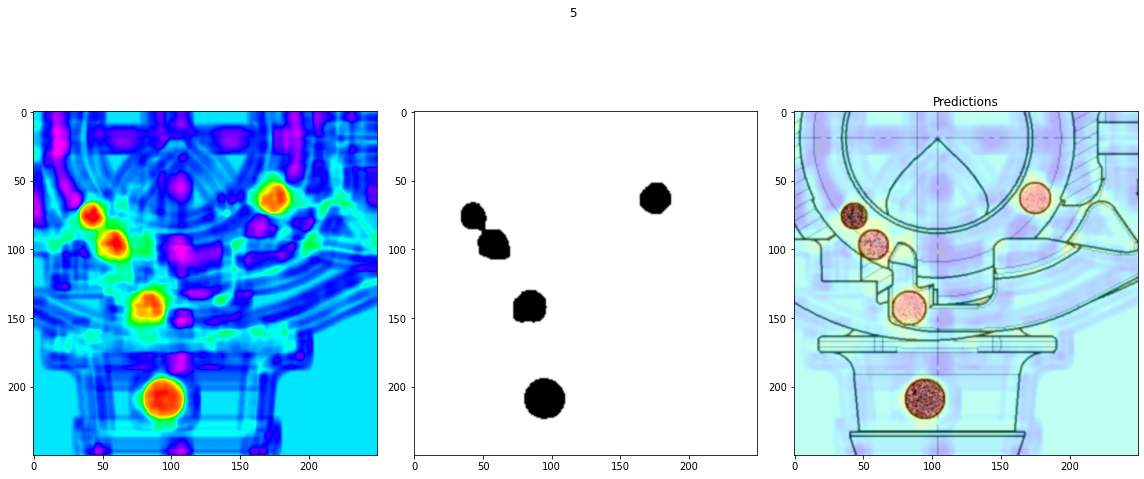

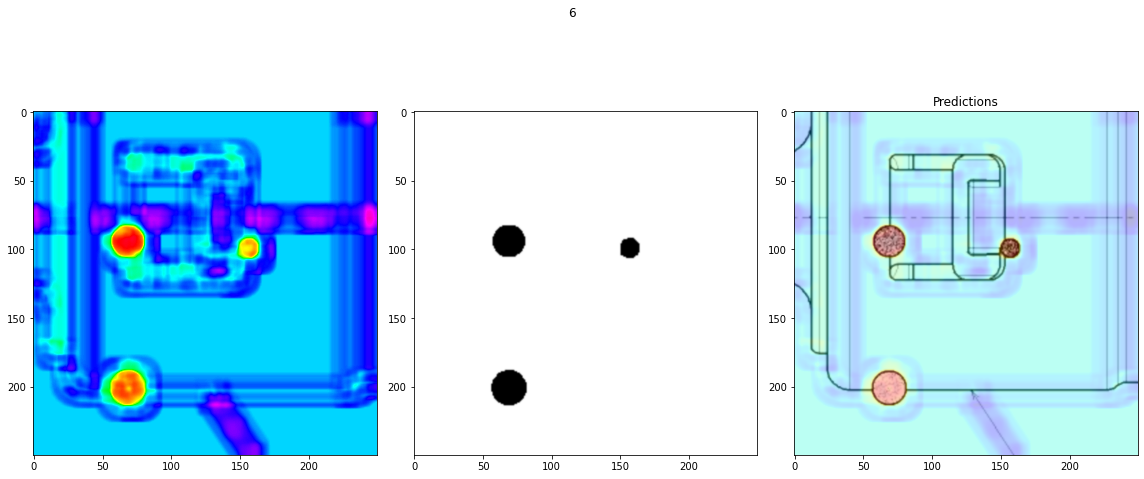

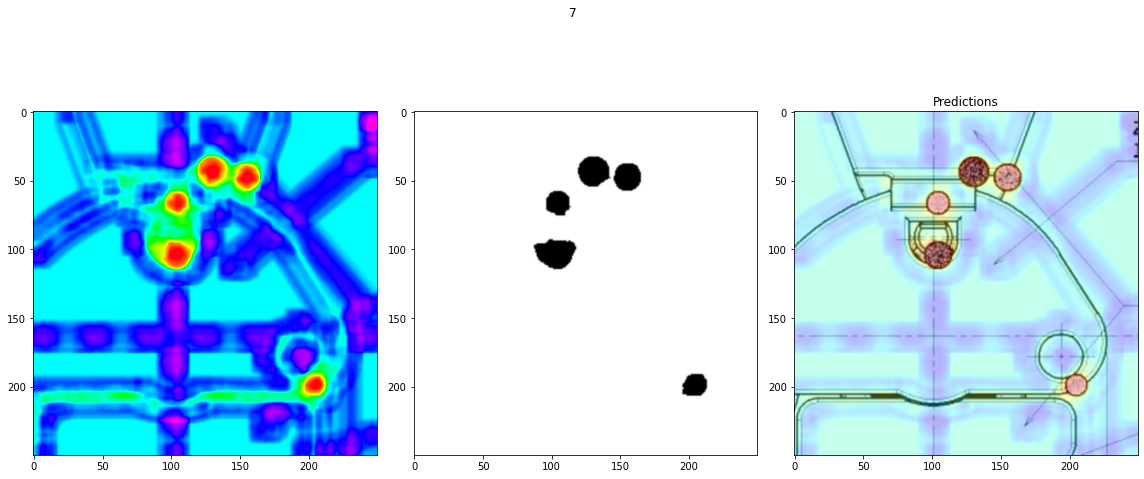

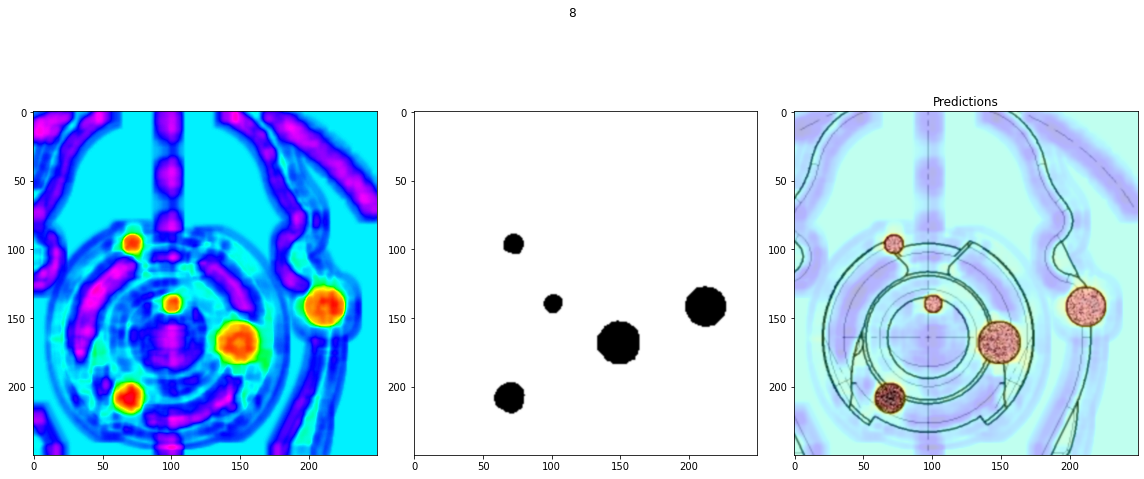

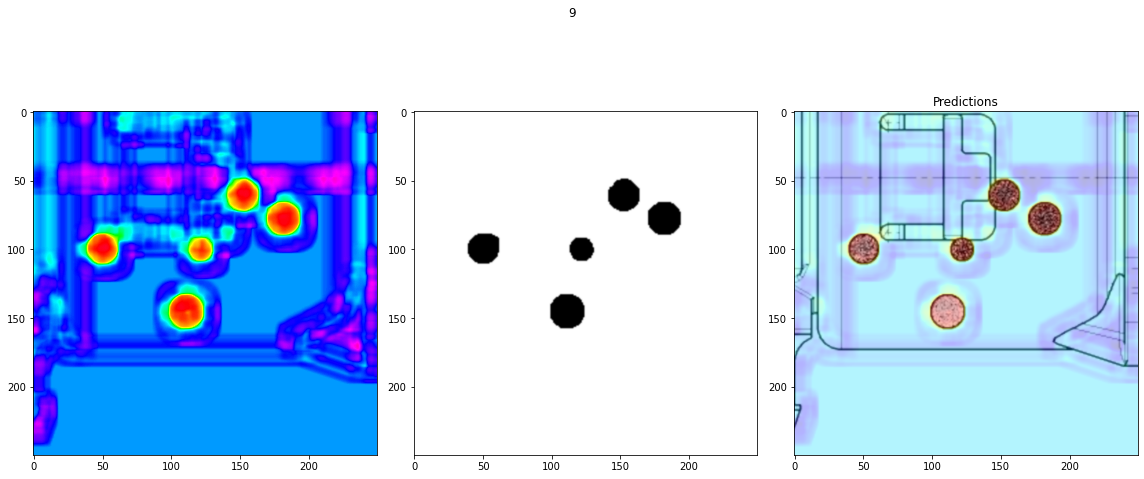

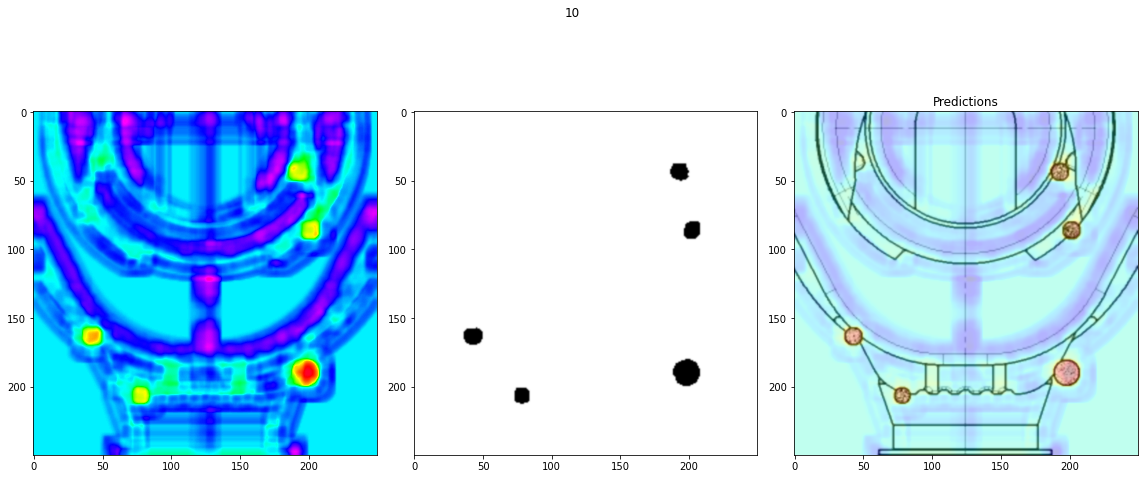

In [ ]:
# model = Net().to(device)
# print(model)
print(device)
torch.cuda.empty_cache()

model.eval()
print('\nCheck:')
with torch.no_grad():
    for i, (x,y) in enumerate(dataloader['valid']):
        x,y=x.to(device),y.to(device)
        del y
        out = model(x)
        # hout,wout = out.size()[2],out.size()[3]
        #Ty = transforms.functional.resize(y,size=(hout,wout),interpolation=transforms.InterpolationMode.NEAREST)
        Tx = transforms.functional.resize(x, OUTPUT_SIZE)
        ml.tensShow(Tx.squeeze(0),out.squeeze(0),i)
        if i == 10:
            break

Le code suivant retourne l'image originale associée aux sorties des différentes couches de convolution et maxPooling. Chaque colonne correspond à un filtre, l'image en haut de chaque colonne correspond à la sortie de la couche, les trois images en dessous correspondent aux zones de l'image originale que le filtre correspondant active le plus.

In [ ]:
def getPatch(target,batch,idx=0,topk=3):
    with torch.no_grad():
        img, label = batch
        img=img[idx].to(device)
        label = label[idx].to(device)

        conv_output = None
        x=img.unsqueeze(0)
        modules=[]

        for module_pos, module in model._modules.items():
            modules.append(module)
            x = module(x)  # Forward

            if module == target:
                break
        # img = unnormalize(img)
        fig = plt.figure(figsize=(16,8))
        fig.add_subplot(topk+2,x.size()[1], 1)
        tr=transforms.ToPILImage()
        im=tr(img.cpu())
        trr = transforms.Resize((244,244))
        im=trr(im)
        plt.imshow(np.array(im))
        for i in range(x.size()[1]):
            fig.add_subplot(topk + 2, x.size()[1], x.size()[1]+i+1)
            x=x.cpu()
            plt.imshow(x[0][i],cmap="afmhot") #cmap="viridis" (autre jeu de couleur)
            plt.axis('off')
            l=x[0][i].view(-1).sort(dim=(0), descending=True)
            best=l[1][:min(topk,l[1].size()[-1])]
            l=[(int(np.floor(best[j]/x.size()[-1]).item()),(best[j]%x.size()[-1]).item()) for j in range(best.size()[-1])]
            for j in range(len(l)):
                idx=l[j]
                crop=_getCropFor(img,idx,modules)
                crop = trr(crop)
                fig.add_subplot(topk + 2, x.size()[1], (j+2)*x.size()[1]+i+1)
                plt.imshow(np.array(crop))
                plt.axis('off')

        plt.show()
        
        
def _getCropFor(img,idx,modules):
    r,c=idx
    interest=(r,c,1,1)
    for m in range(len(modules)-1,-1,-1):
        mo=modules[m]
        if not ((isinstance(mo,torch.nn.Conv2d)) or (isinstance(mo,torch.nn.AvgPool2d))):
          continue
        size=mo.kernel_size
        if isinstance(size,int):
            size=(size,size)
        stride = mo.stride
        if isinstance(stride, int):
            stride=(stride,stride)
        pad=mo.padding
        if isinstance(pad, int):
            pad=(pad,pad)
        r,c,w,h=interest
        newr=r*stride[0]-pad[0]
        newc=c*stride[1]-pad[1]
        neww = (c + w -1) * stride[1] - pad[1] + size[1]-newc
        newh = (r + h-1) * stride[0] - pad[0] + size[0] - newr
        if newr<0:
            newh=newh-np.abs(newr)
            newr=0
        if newc<0:
            neww = neww - np.abs(newc)
            newc=0
        interest=(newr,newc,neww,newh)

    r, c, w, h = interest
    if c+w>img.size()[2]:
        w=img.size()[2]-c
    if r + h > img.size()[1]:
        h = img.size()[1] - r
    tr = transforms.ToPILImage()
    img=tr(img.cpu())
    img=transforms.functional.crop(img, r, c, h, w)
    #print(r, c, h, w)
    return img

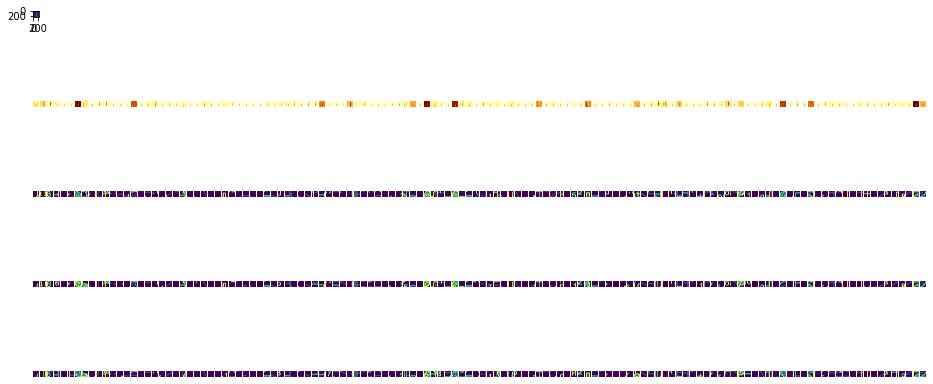

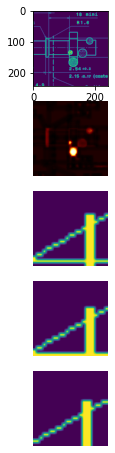

In [ ]:
data=iter(dataloader['train']).next()
getPatch(model.conv1,data)
# getPatch(model.pool1, data)
# getPatch(model.conv2,data)
# getPatch(model.pool2, data)
# getPatch(model.conv3,data)
# getPatch(model.pool3, data)
getPatch(model.conv4,data)

torch.Size([128, 1, 21, 21])
torch.Size([64, 128, 3, 3])


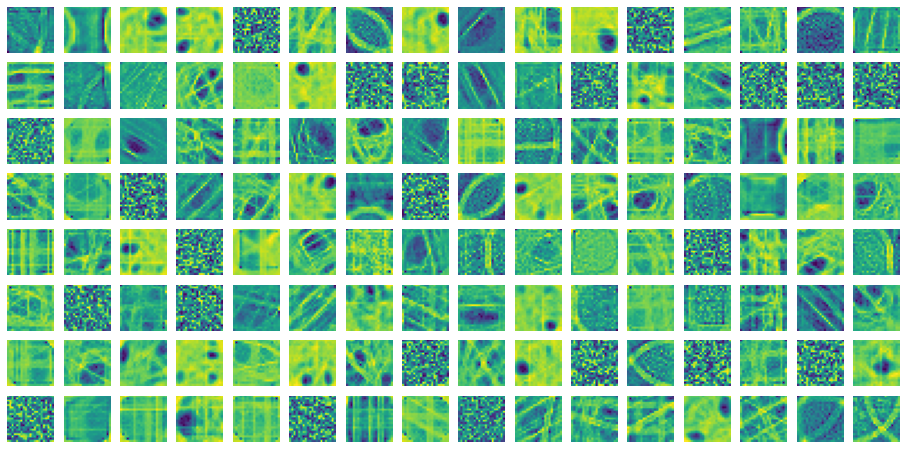

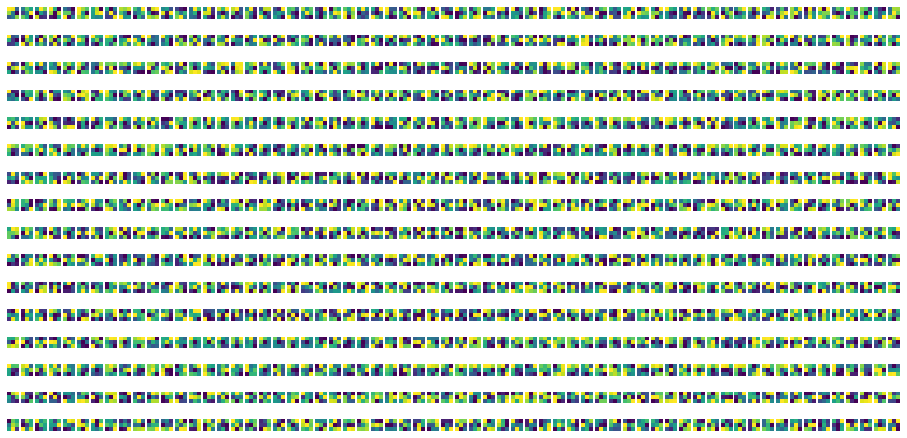

In [ ]:
# Visualize conv filter

kernels = model.conv1.weight.detach()
print(kernels.size())

fig = plt.figure(figsize=(16,8))

n = 1
for idx in range(kernels.size(0)):
  for jdx in range(kernels.size(1)):
    #fig.add_subplot(kernels.size(1),kernels.size(0), n)
    fig.add_subplot(8,16, n)
    plt.imshow(2*kernels[idx][jdx].cpu().detach())
    plt.axis('off')
    n += 1
    # if n == 15:
    #   break

del kernels

kernels = model.conv2.weight.detach()
print(kernels.size())

fig = plt.figure(figsize=(16,8))


n = 1
for idx in range(kernels.size(0)):
  for jdx in range(kernels.size(1)):
    fig.add_subplot(16,64, n)
    plt.imshow(kernels[idx][jdx].cpu().detach())
    plt.axis('off')
    n += 1

    if n == 1024+1:
      break
  if n == 1024+1:
    break
    


torch.Size([1, 1, 500, 500])
torch.Size([1, 1, 250, 250])
torch.Size([64, 250, 250])


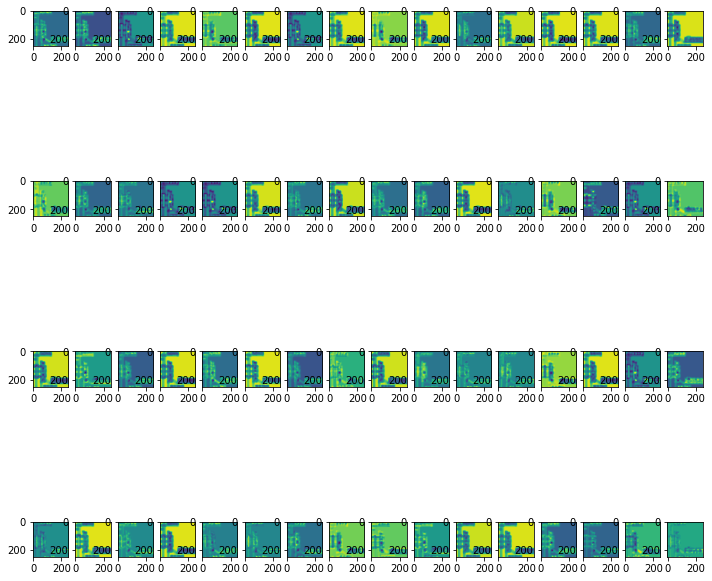

In [ ]:
# Visualize feature maps

idx = 5
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv2.register_forward_hook(get_activation('conv2'))
data, _ = ValidData[idx]
data.unsqueeze_(0)
data= data.to(device)
output = model(data)

print(data.size())
print(output.size())

act = activation['conv2'].squeeze()

print(act.size())
fig = plt.figure(figsize=(12,12))
n=1
for idx in range(act.size(0)):
    #fig.add_subplot(1,act.size(0), n)
    fig.add_subplot(4,16, n)
    plt.imshow(act[idx].cpu())
    n += 1


In [ ]:
for name,_ in model.named_modules():
    print(name)

In [ ]:
# Test data

DATA_DIR_TEST = '/tmp/test'

trans_input = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                      #transforms.Resize(INPUT_SIZE,interpolation=transforms.InterpolationMode.NEAREST),
                      transforms.ToTensor()])

class OringTestDataset(Dataset):

    def __init__(self, root_dir):

        self.root_dir = root_dir
        self.imgs = list(sorted(os.listdir(os.path.join(root_dir, "."))))

    def __len__(self):
        return len(self.imgs)

    def transform(self, x):
        image = trans_input(x)
        return image

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir, ".", self.imgs[idx])
        im_invert = Image.open(img_name).convert('L')
        image = ImageOps.invert(im_invert)
        path = self.imgs[idx]
        x = self.transform(image)
        return x

test_dataset = OringTestDataset(root_dir=DATA_DIR_TEST)
testloader = DataLoader(test_dataset,batch_size=1,shuffle=False,pin_memory=False,num_workers=0)



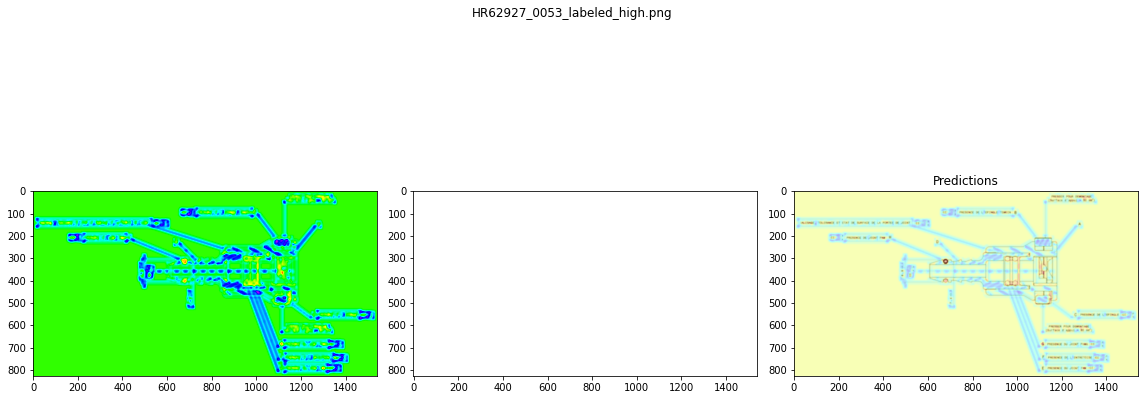

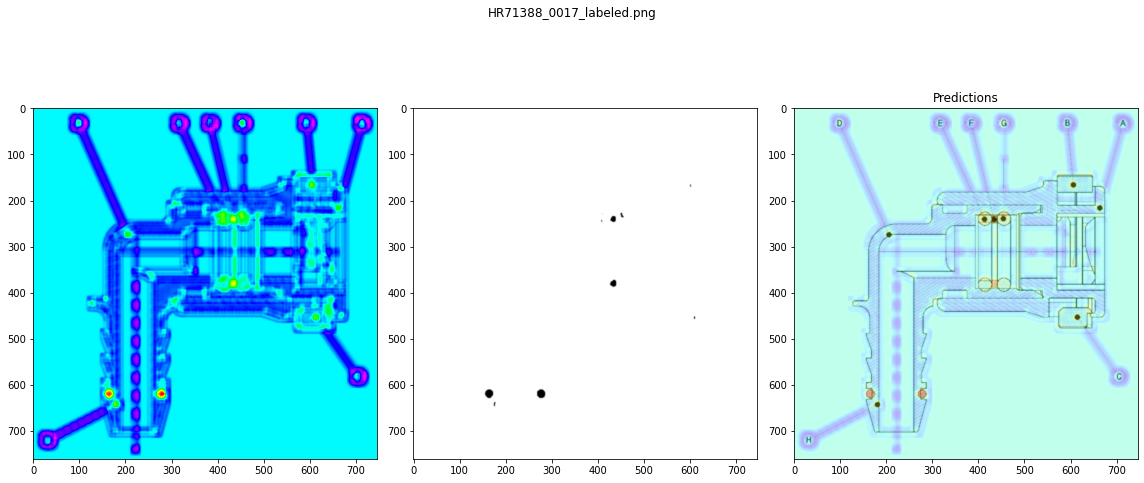

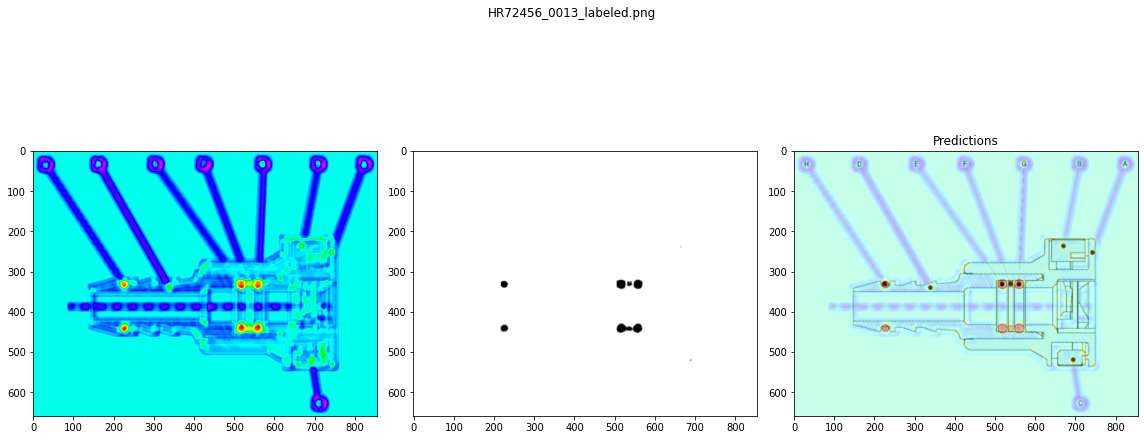

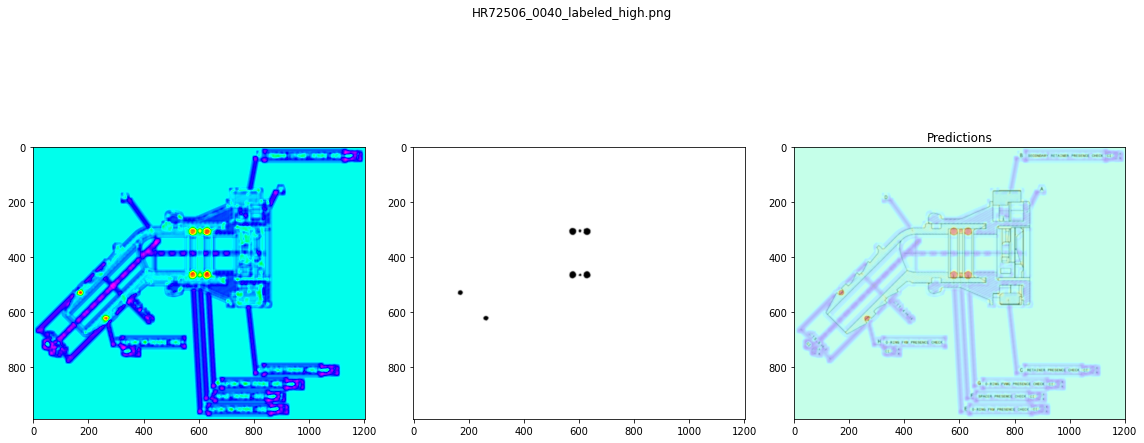

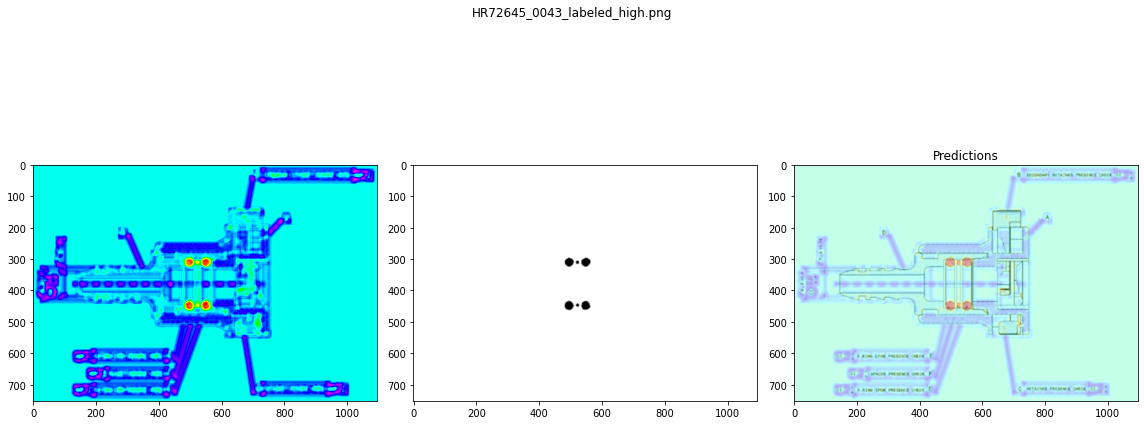

In [ ]:
model.eval()
with torch.no_grad():
    for i, x in enumerate(testloader):
        sample_fname = testloader.dataset.imgs[i]
        x=x.to(device)
        out = model(x)
        x = transforms.functional.resize(x, (out.size()[2],out.size()[3]))
        ml.tensShow(x.squeeze(0),out.squeeze(0),sample_fname)
        if i == 10:
            break